# Libraries

In [1]:
import pandas as pd
import numpy as np
import sys

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score

In [2]:
sys.path.append("../Src/Lib")

import functions

# Data Preprocessing

## Importing

We have data spread across several CSV files, so we create a For Loop to iterate through each Dataset and import it to the Notebook.

To do this, we create two empty Lists: one where we will append the names for the Datasets, and another with the data.

Finally, we combine these names and data together in a Dictionary of Dataframes.

In [3]:
mvps_names = []
mvps_data = []

for x in range(23):
    mvps_names.append("mvp_"+str(2000+x))
    mvps_data.append(pd.read_csv("../Data/Raw/MVP{}.csv".format(2000+x), header = 1))
    
mvp_dfs = dict(zip(mvps_names, mvps_data))

## Cleaning

Now that we have the data loaded, it is time to clean it. Thankfully, our data comes already quite clean, we only need to:

- Drop a useless column
- Create columns with PTS, AST, TRB, STL and BLK per minute, in order to not give the edge to players with higher minutes per game.
- A column with all stats combined per minute.
- Create another column with the year of the MVP to differentiate it with the others once we concatenate them all.
- Clean some values from the Rank column.
- Fill in some missing values.

This is done with another For Loop, we could pospone some of the cleaning and do it once we concatenate all the Datasets together, but since we need to add a ```Year``` column, may as well do the rest of the cleaning at the same time.

We will also save the cleaned Datasets, both the individual years and the concatenated one for later use in Tableau and modeling.

In [4]:
for key, x in zip(mvp_dfs, range(23)):
    mvp_dfs[key] = mvp_dfs[key].drop(columns = mvp_dfs[key].columns[-1])
    mvp_dfs[key]["PTS/M"] = mvp_dfs[key]["PTS"]/mvp_dfs[key]["MP"]
    mvp_dfs[key]["TRB/M"] = mvp_dfs[key]["TRB"]/mvp_dfs[key]["MP"]
    mvp_dfs[key]["AST/M"] = mvp_dfs[key]["AST"]/mvp_dfs[key]["MP"]
    mvp_dfs[key]["STL/M"] = mvp_dfs[key]["STL"]/mvp_dfs[key]["MP"]
    mvp_dfs[key]["BLK/M"] = mvp_dfs[key]["BLK"]/mvp_dfs[key]["MP"]
    mvp_dfs[key]["Stats/M"] = mvp_dfs[key]["PTS/M"]+mvp_dfs[key]["TRB/M"]+mvp_dfs[key]["AST/M"]+mvp_dfs[key]["STL/M"]+mvp_dfs[key]["BLK/M"]
    mvp_dfs[key]["Year"] = (2000+x)
    mvp_dfs[key] = mvp_dfs[key].fillna(0)
    mvp_dfs[key]["Rank"] = mvp_dfs[key]["Rank"].replace("T",'',regex=True).astype(int)
    mvp_dfs[key].to_csv("../Data/Cleaned/CleanMVP{}.csv".format(2000+x), index = False)

In [5]:
mvps = pd.concat(mvp_dfs.values(), ignore_index = True)
mvps.shape

(326, 27)

In [6]:
mvps.head()

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,FT%,WS,WS/48,PTS/M,TRB/M,AST/M,STL/M,BLK/M,Stats/M,Year
0,1,Shaquille O'Neal,27,LAL,120.0,1207.0,1210,0.998,79,40.0,...,0.524,18.6,0.283,0.742500,0.340000,0.095000,0.012500,0.075000,1.265000,2000
1,2,Kevin Garnett,23,MIN,0.0,408.0,1210,0.337,81,40.0,...,0.765,11.6,0.172,0.572500,0.295000,0.125000,0.037500,0.040000,1.070000,2000
2,3,Alonzo Mourning,29,MIA,0.0,367.0,1210,0.303,79,34.8,...,0.711,12.9,0.226,0.623563,0.272989,0.045977,0.014368,0.106322,1.063218,2000
3,4,Karl Malone,36,UTA,0.0,312.0,1210,0.258,82,35.9,...,0.797,15.3,0.249,0.710306,0.264624,0.103064,0.027855,0.025070,1.130919,2000
4,5,Tim Duncan,23,SAS,0.0,248.0,1210,0.205,74,38.9,...,0.761,13.0,0.218,0.596401,0.318766,0.082262,0.023136,0.056555,1.077121,2000


In [7]:
mvps.to_csv("../Data/Cleaned/CleanMVPs.csv", index = False)

# Data Processing

For the rest of the Notebook, we are going to drop ```Player```, ```Tm```, ```First```, ```Pts Won```, ```Pts Max``` and ```Year```, as this are columns that are either not useful or directly correlated to the MVP.

In [8]:
mvps = mvps.drop(columns = ["Player", "Tm", "First", "Pts Won", "Pts Max", "Year"])

## First Model

- Linear Regression
- Target: Rank

We drop the column ```Shares``` as this column is only available once the MVP is awarded.

In [9]:
mvps_rank = mvps.drop(columns = "Share")

Now we call a custom function that drops columns based on the correlation towards our target column, in this case ```Rank```.

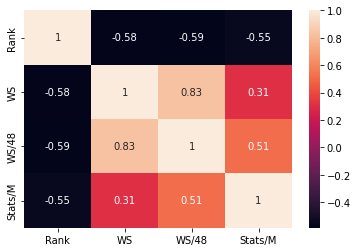

In [10]:
mvps_rank = functions.correlation(mvps_rank, 0, 0.5)

Well, we are left with very few columns.

We are going to drop WS rather than WS/48, as this last one is more fair for players that played less games due to lockouts.

In [11]:
mvps_rank = mvps_rank.drop(columns = "WS")

### X/y Split

In [12]:
rank_X = mvps_rank.drop(columns = "Rank")
rank_y = mvps_rank["Rank"]

### Train/Test Split

In [13]:
rank_X_train, rank_X_test, rank_y_train, rank_y_test = train_test_split(rank_X, rank_y, test_size = 0.22, random_state = 22)

### Transformer

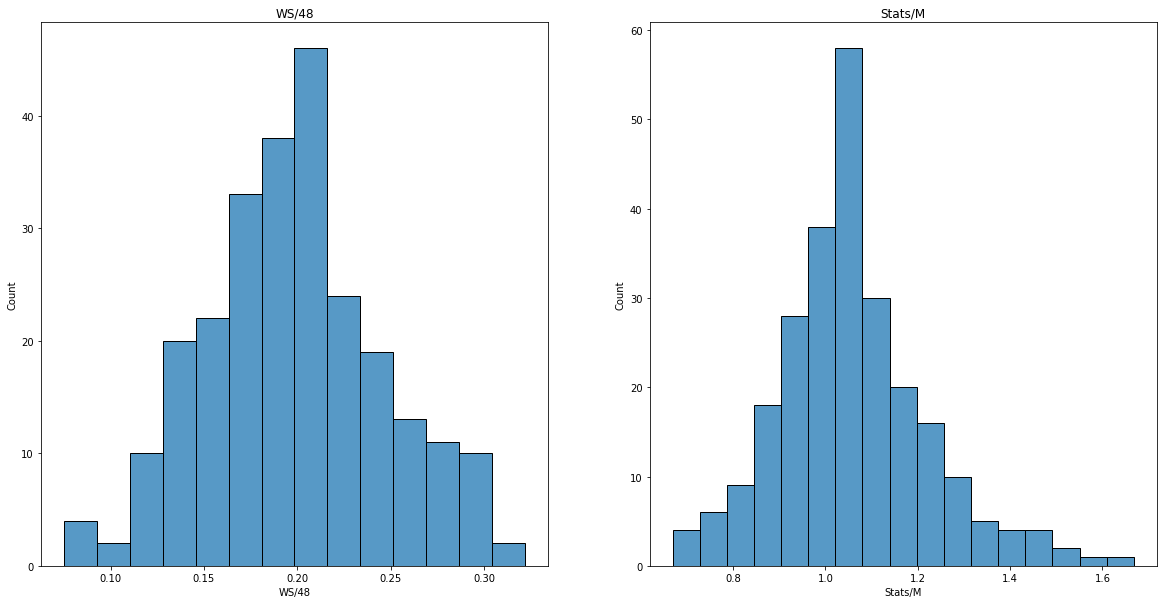

In [14]:
functions.plot_maker(rank_X_train)

In [15]:
rank_pt = PowerTransformer().fit(rank_X_train)

with open("../Transformers/rank_pt.pkl", "wb") as file:
    pickle.dump(rank_pt, file)

rank_X_train_pt = rank_pt.transform(rank_X_train)
rank_X_train_pt = pd.DataFrame(rank_X_train_pt, columns = rank_X_train.columns, index = rank_X_train.index)

rank_X_test_pt = rank_pt.transform(rank_X_test)
rank_X_test_pt = pd.DataFrame(rank_X_test_pt, columns = rank_X_test.columns, index = rank_X_test.index)

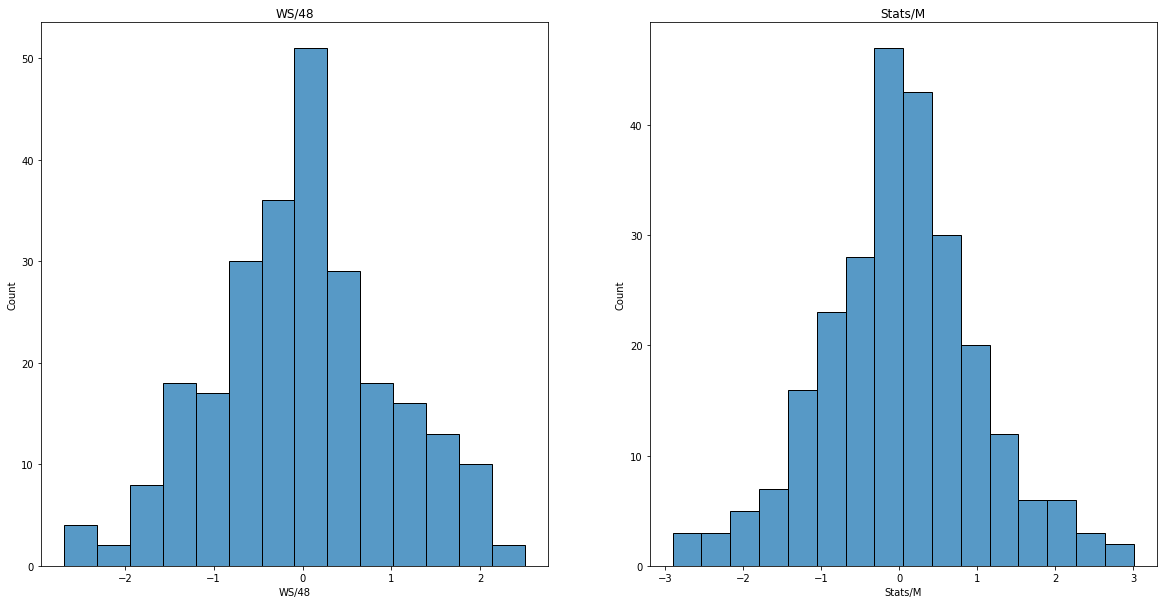

In [16]:
functions.plot_maker(rank_X_train_pt)

### Scaler

In [17]:
rank_scaler = MinMaxScaler().fit(rank_X_train_pt)

with open("../Scalers/rank_scaler.pkl", "wb") as file:
    pickle.dump(rank_scaler, file)

rank_X_train_pt_mm = rank_scaler.transform(rank_X_train_pt)
rank_X_train_pt_mm = pd.DataFrame(rank_X_train_pt_mm, columns = rank_X_train_pt.columns, index = rank_X_train_pt.index)

rank_X_test_pt_mm = rank_scaler.transform(rank_X_test_pt)
rank_X_test_pt_mm = pd.DataFrame(rank_X_test_pt_mm, columns = rank_X_test_pt.columns, index = rank_X_test_pt.index)

### Model

In [18]:
rank_lr = LinearRegression().fit(rank_X_train_pt_mm, rank_y_train)

with open("../Models/rank_lr.pkl","wb") as file:
    pickle.dump(rank_lr, file)

### Validation

In [19]:
rank_train_y_pred = rank_lr.predict(rank_X_train_pt_mm)
rank_test_y_pred = rank_lr.predict(rank_X_test_pt_mm)

print("First Model Train Score: {:.2f}".format(r2_score(rank_y_train, rank_train_y_pred),2))
print("First Model Test Score: {:.2f}".format(r2_score(rank_y_test, rank_test_y_pred),2))

First Model Train Score: 0.46
First Model Test Score: 0.33


### Visualization

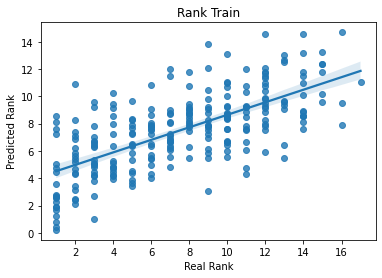

In [20]:
sns.regplot(x = rank_y_train, y = rank_train_y_pred).set(title='Rank Train')
plt.xlabel("Real Rank")
plt.ylabel("Predicted Rank")
plt.savefig("../Slides/Images/RankTrain.png") 

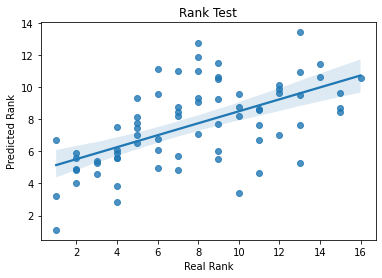

In [21]:
sns.regplot(x = rank_y_test, y = rank_test_y_pred).set(title='Rank Test')
plt.xlabel("Real Rank")
plt.ylabel("Predicted Rank")
plt.savefig("../Slides/Images/RankTest.png") 

## Second model:

- Linear Regression
- Target = Share

In this case we drop the column ```Rank``` as, like before, it is only known when the MVP is awarded.

In [22]:
mvps_share = mvps.drop(columns = "Rank")

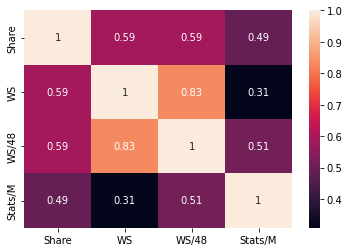

In [23]:
mvps_share = functions.correlation(mvps_share, 1, 0.4)

In [24]:
mvps_share = mvps_share.drop(columns = "WS")

### X/y Split

In [25]:
share_X = mvps_share.drop(columns = "Share")
share_y = mvps_share["Share"]

### Train/Test Split

In [26]:
share_X_train, share_X_test, share_y_train, share_y_test = train_test_split(share_X, share_y, test_size = 0.22, random_state = 22)

### Transformer

In [27]:
share_pt = PowerTransformer().fit(share_X_train)

with open("../Transformers/share_pt.pkl", "wb") as file:
    pickle.dump(share_pt, file)

share_X_train_pt = share_pt.transform(share_X_train)
share_X_train_pt = pd.DataFrame(share_X_train_pt, columns = share_X_train.columns, index = share_X_train.index)

share_X_test_pt = share_pt.transform(share_X_test)
share_X_test_pt = pd.DataFrame(share_X_test_pt, columns = share_X_test.columns, index = share_X_test.index)

### Scaler

In [28]:
share_scaler = MinMaxScaler().fit(share_X_train_pt)

with open("../Scalers/share_scaler.pkl", "wb") as file:
    pickle.dump(share_scaler, file)

share_X_train_pt_mm = share_scaler.transform(share_X_train_pt)
share_X_train_pt_mm = pd.DataFrame(share_X_train_pt_mm, columns = share_X_train_pt.columns, index = share_X_train_pt.index)

share_X_test_pt_mm = share_scaler.transform(share_X_test_pt)
share_X_test_pt_mm = pd.DataFrame(share_X_test_pt_mm, columns = share_X_test_pt.columns, index = share_X_test_pt.index)

### Model

In [29]:
share_lr = LinearRegression().fit(share_X_train_pt_mm, share_y_train)

with open("../Models/share_lr.pkl", "wb") as file:
    pickle.dump(share_lr, file)

### Validation

In [30]:
share_train_y_pred = share_lr.predict(share_X_train_pt_mm)
share_test_y_pred = share_lr.predict(share_X_test_pt_mm)

print("Second Model Train Score: {:.2f}".format(r2_score(share_y_train, share_train_y_pred),2))
print("Second Model Test Score: {:.2f}".format(r2_score(share_y_test, share_test_y_pred),2))

Second Model Train Score: 0.38
Second Model Test Score: 0.34


### Visualization

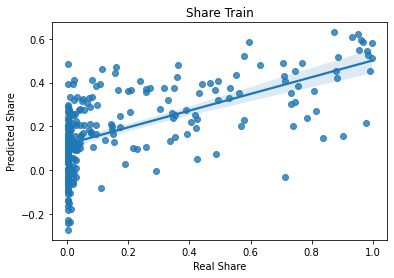

In [31]:
sns.regplot(x = share_y_train, y = share_train_y_pred).set(title="Share Train")
plt.xlabel("Real Share")
plt.ylabel("Predicted Share")
plt.savefig("../Slides/Images/ShareTrain.png") 

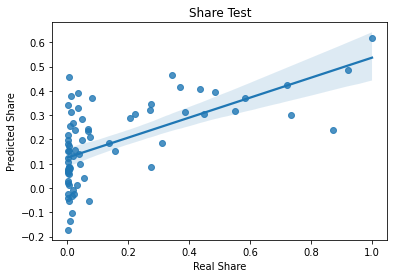

In [32]:
sns.regplot(x = share_y_test, y = share_test_y_pred).set(title="Share Test")
plt.xlabel("Real Share")
plt.ylabel("Predicted Share")
plt.savefig("../Slides/Images/ShareTest.png") 

## Third model:

- Logistic Regression
- Target = Top3

In [33]:
mvps["Top3"] = mvps["Rank"] <= 3
mvps.head()

,Rank,Age,Share,G,MP,PTS,TRB,AST,STL,BLK,...,FT%,WS,WS/48,PTS/M,TRB/M,AST/M,STL/M,BLK/M,Stats/M,Top3
0,1,27,0.998,79,40.0,29.7,13.6,3.8,0.5,3.0,...,0.524,18.6,0.283,0.742500,0.340000,0.095000,0.012500,0.075000,1.265000,True
1,2,23,0.337,81,40.0,22.9,11.8,5.0,1.5,1.6,...,0.765,11.6,0.172,0.572500,0.295000,0.125000,0.037500,0.040000,1.070000,True
2,3,29,0.303,79,34.8,21.7,9.5,1.6,0.5,3.7,...,0.711,12.9,0.226,0.623563,0.272989,0.045977,0.014368,0.106322,1.063218,True
3,4,36,0.258,82,35.9,25.5,9.5,3.7,1.0,0.9,...,0.797,15.3,0.249,0.710306,0.264624,0.103064,0.027855,0.025070,1.130919,False
4,5,23,0.205,74,38.9,23.2,12.4,3.2,0.9,2.2,...,0.761,13.0,0.218,0.596401,0.318766,0.082262,0.023136,0.056555,1.077121,False


### X/y Split

In [34]:
top3_X = mvps[["WS/48", "Stats/M"]]
top3_y = mvps["Top3"]

### Train/Test Split

In [35]:
top3_X_train, top3_X_test, top3_y_train, top3_y_test = train_test_split(top3_X, top3_y, test_size = 0.22, random_state = 22)

### Transformer

In [36]:
top3_pt = PowerTransformer().fit(top3_X_train)

with open("../Transformers/top3_pt.pkl","wb") as file:
    pickle.dump(top3_pt, file)

top3_X_train_pt = top3_pt.transform(top3_X_train)
top3_X_train_pt = pd.DataFrame(top3_X_train_pt, columns = top3_X_train.columns, index = top3_X_train.index)

top3_X_test_pt = top3_pt.transform(top3_X_test)
top3_X_test_pt = pd.DataFrame(top3_X_test_pt, columns = top3_X_test.columns, index = top3_X_test.index)

### Scaler

In [37]:
top3_scaler = MinMaxScaler().fit(top3_X_train_pt)

with open("../Scalers/top3_scaler.pkl","wb") as file:
    pickle.dump(top3_scaler, file)

top3_X_train_pt_mm = top3_scaler.transform(top3_X_train_pt)
top3_X_train_pt_mm = pd.DataFrame(top3_X_train_pt_mm, columns = top3_X_train_pt.columns, index = top3_X_train_pt.index)

top3_X_test_pt_mm = top3_scaler.transform(top3_X_test_pt)
top3_X_test_pt_mm = pd.DataFrame(top3_X_test_pt_mm, columns = top3_X_test_pt.columns, index = top3_X_test_pt.index)

### Model

In [38]:
top3_lr = LogisticRegression(random_state = 22, solver = "lbfgs").fit(top3_X_train_pt_mm, top3_y_train)

with open("../Models/top3_lr.pkl","wb") as file:
    pickle.dump(top3_lr, file)

### Validation

In [39]:
top3_lr_y_train_pred = top3_lr.predict(top3_X_train_pt_mm)
top3_lr_y_test_pred = top3_lr.predict(top3_X_test_pt_mm)

print("Third Model Train Kappa Score: {:.2f}".format((cohen_kappa_score(top3_y_train, top3_lr_y_train_pred))))
print("Third Model Test Kappa Score: {:.2f}".format(cohen_kappa_score(top3_y_test, top3_lr_y_test_pred)))

Third Model Train Kappa Score: 0.40
Third Model Test Kappa Score: 0.24


### Visualization

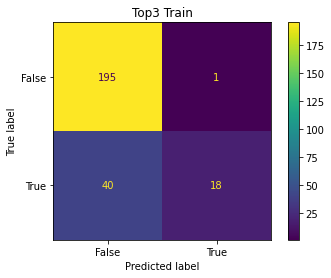

In [40]:
top3_cm_train = confusion_matrix(top3_y_train, top3_lr_y_train_pred)
disp = ConfusionMatrixDisplay(top3_cm_train,display_labels=top3_lr.classes_);
disp.plot()
plt.title("Top3 Train")
plt.savefig("../Slides/Images/Top3Train.png")

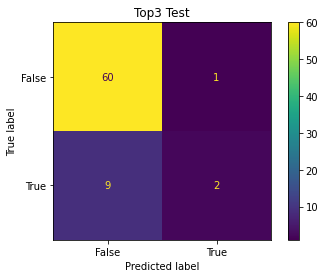

In [41]:
top3_cm_test = confusion_matrix(top3_y_test, top3_lr_y_test_pred)
disp = ConfusionMatrixDisplay(top3_cm_test,display_labels=top3_lr.classes_);
disp.plot()
plt.title("Top3 Test")
plt.savefig("../Slides/Images/Top3Test.png")

## Fourth model:

- Logistic Regression
- Target = Top5

In [42]:
mvps["Top5"] = mvps["Rank"] <= 5
mvps.head()

,Rank,Age,Share,G,MP,PTS,TRB,AST,STL,BLK,...,WS,WS/48,PTS/M,TRB/M,AST/M,STL/M,BLK/M,Stats/M,Top3,Top5
0,1,27,0.998,79,40.0,29.7,13.6,3.8,0.5,3.0,...,18.6,0.283,0.742500,0.340000,0.095000,0.012500,0.075000,1.265000,True,True
1,2,23,0.337,81,40.0,22.9,11.8,5.0,1.5,1.6,...,11.6,0.172,0.572500,0.295000,0.125000,0.037500,0.040000,1.070000,True,True
2,3,29,0.303,79,34.8,21.7,9.5,1.6,0.5,3.7,...,12.9,0.226,0.623563,0.272989,0.045977,0.014368,0.106322,1.063218,True,True
3,4,36,0.258,82,35.9,25.5,9.5,3.7,1.0,0.9,...,15.3,0.249,0.710306,0.264624,0.103064,0.027855,0.025070,1.130919,False,True
4,5,23,0.205,74,38.9,23.2,12.4,3.2,0.9,2.2,...,13.0,0.218,0.596401,0.318766,0.082262,0.023136,0.056555,1.077121,False,True


### X/y Split

In [43]:
top5_X = mvps[["WS/48", "Stats/M"]]
top5_y = mvps["Top5"]

### Train/Test Split

In [44]:
top5_X_train, top5_X_test, top5_y_train, top5_y_test = train_test_split(top5_X, top5_y, test_size = 0.22, random_state = 22)

### Transformer

In [45]:
top5_pt = PowerTransformer().fit(top5_X_train)

with open("../Transformers/top5_pt.pkl","wb") as file:
    pickle.dump(top5_pt, file)

top5_X_train_pt = top5_pt.transform(top5_X_train)
top5_X_train_pt = pd.DataFrame(top5_X_train_pt, columns = top5_X_train.columns, index = top5_X_train.index)

top5_X_test_pt = top5_pt.transform(top5_X_test)
top5_X_test_pt = pd.DataFrame(top5_X_test_pt, columns = top5_X_test.columns, index = top5_X_test.index)

### Scaler

In [46]:
top5_scaler = MinMaxScaler().fit(top5_X_train_pt)

with open("../Scalers/top5_scaler.pkl","wb") as file:
    pickle.dump(top5_scaler, file)

top5_X_train_pt_mm = top5_scaler.transform(top5_X_train_pt)
top5_X_train_pt_mm = pd.DataFrame(top5_X_train_pt_mm, columns = top5_X_train_pt.columns, index = top5_X_train_pt.index)

top5_X_test_pt_mm = top5_scaler.transform(top5_X_test_pt)
top5_X_test_pt_mm = pd.DataFrame(top5_X_test_pt_mm, columns = top5_X_test_pt.columns, index = top5_X_test_pt.index)

### Model

In [47]:
top5_lr = LogisticRegression(random_state = 22, solver = "lbfgs").fit(top5_X_train_pt_mm, top5_y_train)

with open("../Models/top5_lr.pkl","wb") as file:
    pickle.dump(top5_lr, file)

### Validation

In [48]:
top5_lr_y_train_pred = top5_lr.predict(top5_X_train_pt_mm)
top5_lr_y_test_pred = top5_lr.predict(top5_X_test_pt_mm)

print("Fourth Model Train Kappa Score: {:.2f}".format(cohen_kappa_score(top5_y_train, top5_lr_y_train_pred)))
print("Fourth Model Test Kappa Score: {:.2f}".format(cohen_kappa_score(top5_y_test, top5_lr_y_test_pred)))

Fourth Model Train Kappa Score: 0.54
Fourth Model Test Kappa Score: 0.36


### Visualization

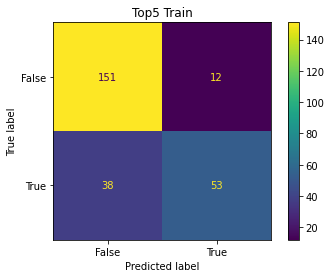

In [49]:
top5_cm_train = confusion_matrix(top5_y_train, top5_lr_y_train_pred)
disp = ConfusionMatrixDisplay(top5_cm_train,display_labels=top5_lr.classes_);
disp.plot()
plt.title("Top5 Train")
plt.savefig("../Slides/Images/Top5Train.png")

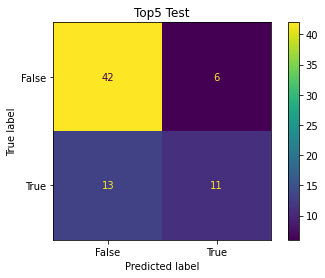

In [50]:
top5_cm_test = confusion_matrix(top5_y_test, top5_lr_y_test_pred)
disp = ConfusionMatrixDisplay(top5_cm_test,display_labels=top5_lr.classes_);
disp.plot()
plt.title("Top5 Test")
plt.savefig("../Slides/Images/Top5Test.png")

## Fifth model:

- MinMax before concat
- Linear Regression
- Target: Rank

For this model we are going to try something different: instead of comparing all the players throughout the years, we are going to rank them only against players of the same year.

This means that the player with the best stats for each year will have a 1 in the Stat/M column and the worst will have a 0, the same will happen to the WS/48 column.

This is done applying a MinMaxScaler BEFORE concatenating all the Datasets together.

With this we want to reduce the impact of the steadily increase of Stats/M that the league has been experiencing this past years.

In [51]:
mvps_names_X = []
mvps_names_y = []
mvps_data_X = []
mvps_data_y = []

for x in range(23):
    mvps_names_X.append("mvp"+str(2000+x)+"_X")
    mvps_names_y.append("mvp"+str(2000+x)+"_y")

for x in range(23):
    y = pd.read_csv("../Data/Cleaned/CleanMVP{}.csv".format(2000+x))
    mvps_data_X.append(y[["WS/48", "Stats/M"]])
    mvps_data_y.append(y["Rank"])

In [52]:
mvps_X_dfs = dict(zip(mvps_names_X, mvps_data_X))
mvps_y_dfs = dict(zip(mvps_names_y, mvps_data_y))

for value in mvps_X_dfs:
    mvps_scaler = MinMaxScaler().fit(mvps_X_dfs[value])
    mvps_X_dfs[value] = pd.DataFrame(mvps_scaler.transform(mvps_X_dfs[value]), columns = mvps_X_dfs[value].columns, index = mvps_X_dfs[value].index)

In [53]:
mvps_X = pd.concat(mvps_X_dfs.values(), ignore_index = True)
mvps_y = pd.concat(mvps_y_dfs.values(), ignore_index = True)

In [54]:
mvps_X.to_csv("../Data/Cleaned/MVPs_X.csv", index = False)
mvps_y.to_csv("../Data/Cleaned/MVPs_y.csv", index = False)

In [55]:
mvps_X.head()

,WS/48,Stats/M
0,1.000000,1.000000
1,0.343195,0.672612
2,0.662722,0.661226
3,0.798817,0.774890
4,0.615385,0.684567


In [56]:
mvps_y.head()

0    1
1    2
2    3
3    4
4    5
Name: Rank, dtype: int64

### Train/Test Split

In [57]:
mvps_X_train, mvps_X_test, mvps_y_train, mvps_y_test = train_test_split(mvps_X, mvps_y, test_size = 0.3, random_state = 22)

### Transformer

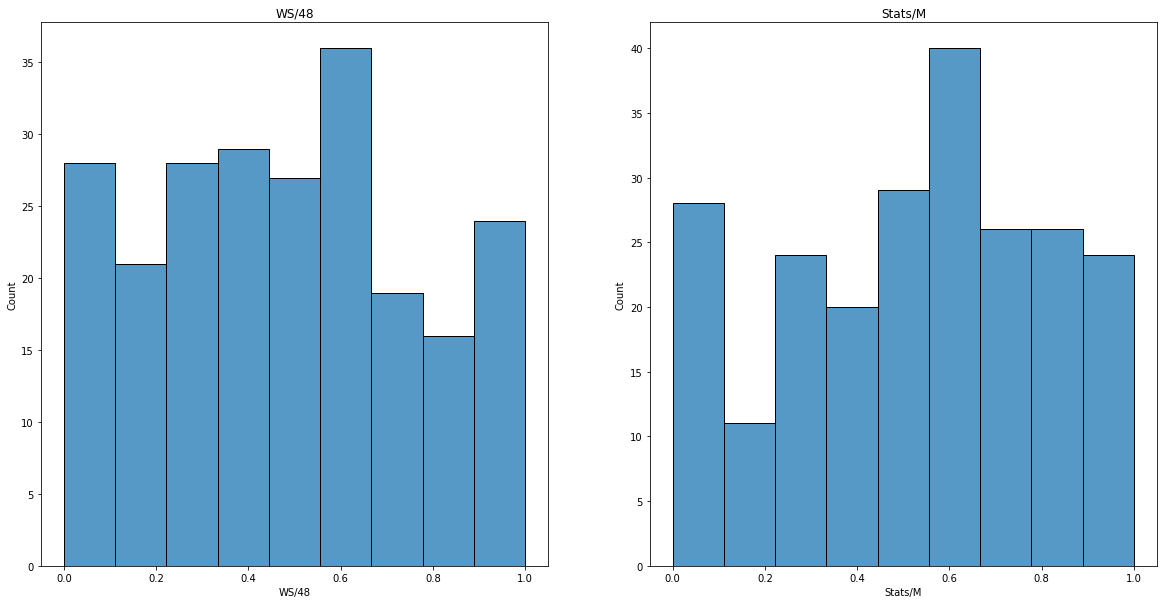

In [58]:
functions.plot_maker(mvps_X_train)

In [59]:
mvps_pt = PowerTransformer().fit(mvps_X_train)

with open("../Transformers/mvps_pt.pkl", "wb") as file:
    pickle.dump(mvps_pt, file)
    
mvps_X_train_pt = mvps_pt.transform(mvps_X_train)
mvps_X_train_pt = pd.DataFrame(mvps_X_train_pt, columns = mvps_X_train.columns, index = mvps_X_train.index)

mvps_X_test_pt = mvps_pt.transform(mvps_X_test)
mvps_X_test_pt = pd.DataFrame(mvps_X_test_pt, columns = mvps_X_test.columns, index = mvps_X_test.index)

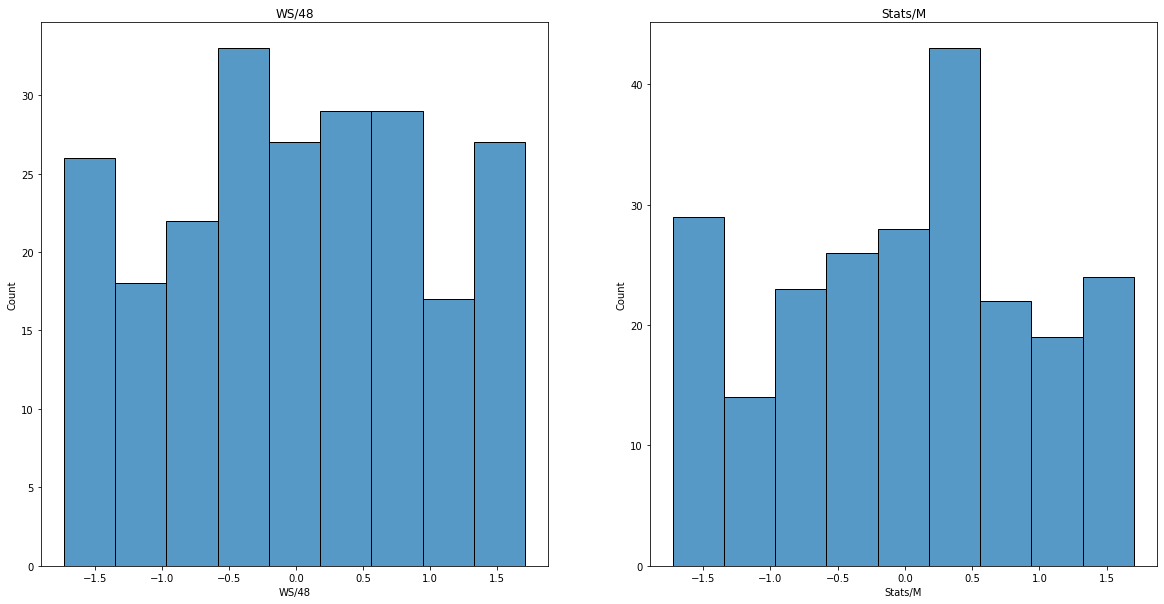

In [60]:
functions.plot_maker(mvps_X_train_pt)

### Model

In [61]:
mvps_lr = LinearRegression().fit(mvps_X_train_pt, mvps_y_train)

with open("../Models/mvps_lr.pkl", "wb") as file:
    pickle.dump(mvps_lr, file)

### Validation

In [62]:
mvps_y_train_pred = mvps_lr.predict(mvps_X_train_pt)
mvps_y_test_pred = mvps_lr.predict(mvps_X_test_pt)

print("Fifth Model Train Score: {:.2f}".format(r2_score(mvps_y_train, mvps_y_train_pred)))
print("Fifth Model Train Score: {:.2f}".format(r2_score(mvps_y_test, mvps_y_test_pred)))

Fifth Model Train Score: 0.38
Fifth Model Train Score: 0.29


### Visualization

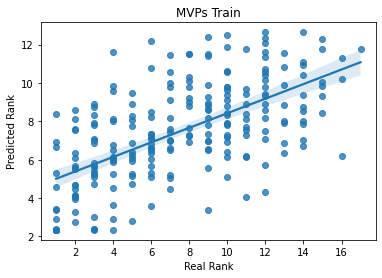

In [63]:
sns.regplot(x = mvps_y_train, y = mvps_y_train_pred).set(title="MVPs Train")
plt.xlabel("Real Rank")
plt.ylabel("Predicted Rank")
plt.savefig("../Slides/Images/MVPsTrain.png")

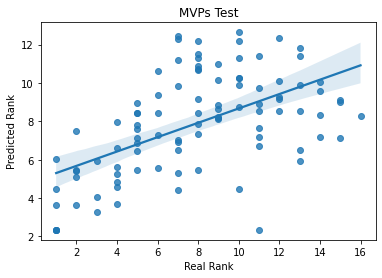

In [64]:
sns.regplot(x = mvps_y_test, y = mvps_y_test_pred).set(title="MVPs Test")
plt.xlabel("Real Rank")
plt.ylabel("Predicted Rank")
plt.savefig("../Slides/Images/MVPsTest.png")